In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

여기서 문제점:
로컬에서 작업하는 경우, https://github.com/ayoolaolafenwa/PixelLib/issues/152 이 부분을 참고했는데,

pixellib 라이브러리에서 semantic_segmentation을 불러오는 과정에서 

ImportError: cannot import name 'BatchNormalization' from 'tensorflow.python.keras.layers' (/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/layers/init.py)

이러한 오류가 발생해서 작업이 불가했는데

Pixellib folder -> semantic -> deeplab.py 를 찾아서
Replace this 
"from tensorflow.python.keras.layers import BatchNormalization" with 
"from keras.layers.normalization.batch_normalization import BatchNormalization"

이렇게 바꾸었더니 해결했음.

(793, 1070, 3)


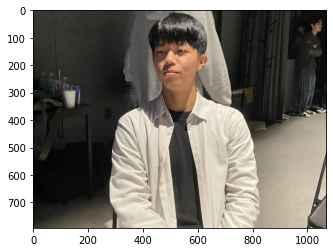

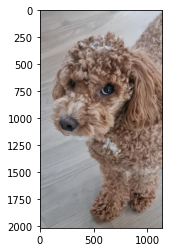

In [23]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image1.png'  
img_orig = cv2.imread(img_path) 

img2_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image2.png'  
img2_orig = cv2.imread(img2_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 사진은 친구 사진을 이용

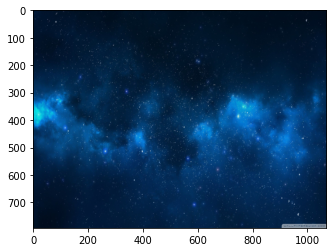

In [7]:
chroma_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma.png'  
chroma = cv2.imread(chroma_path) 

plt.imshow(cv2.cvtColor(chroma, cv2.COLOR_BGR2RGB))
plt.show()

## 배경 크로마키 할 것

In [5]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fc2844acdc0>)

여기는 로컬로 작업하려니까 안 돼서 아이펠 쥬피터로 넘어왔는데, 왜인지는 모르겠으나 모델 호출에서부터 잘 안됐음

추측하기를 pixellib 을 설치하는 과정에서 버전 호환이 계속 충돌나는 이슈가 있어서 그럴 것 같은데, 당장은 원인을 파악하고 해결하는 데에는 벅차서 아이펠을 이용하기로 결정

In [16]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [ ]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

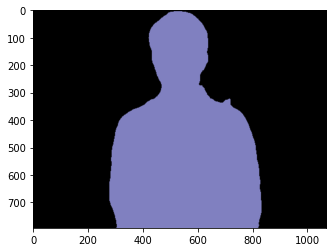

In [25]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
plt.imshow(output)
plt.show()

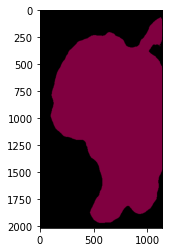

In [26]:
segvalues2, output2 = model.segmentAsPascalvoc(img2_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
plt.imshow(output2)
plt.show()

In [29]:
#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [31]:
print(colormap[15]) ## 사람
print(colormap[12]) ## 개

[192 128 128]
[ 64   0 128]


In [32]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서
seg_color2 = (128,0,64)

(793, 1070)


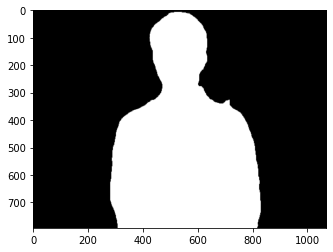

In [33]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

(2016, 1134)


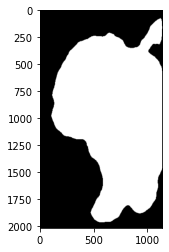

In [35]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map2 = np.all(output2==seg_color2, axis=-1) 
print(seg_map2.shape) 
plt.imshow(seg_map2, cmap='gray')
plt.show()

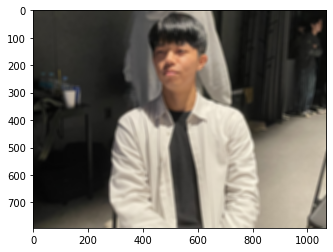

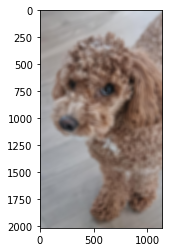

In [42]:
#블러처리

img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

img2_orig_blur = cv2.blur(img2_orig, (35,35))
plt.imshow(cv2.cvtColor(img2_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

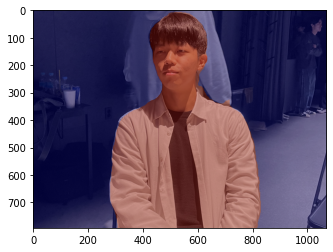

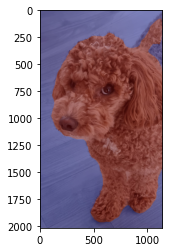

In [61]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()
img2_show = img2_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255
img2_mask = seg_map2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
color2_mask = cv2.applyColorMap(img2_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
img2_show = cv2.addWeighted(img2_show, 0.6, color2_mask, 0.4, 0.0)

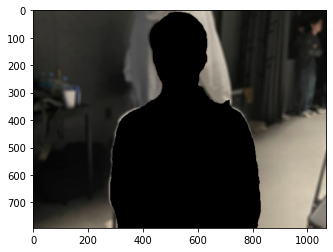

In [66]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


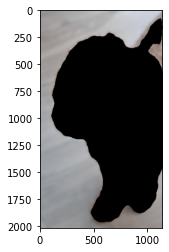

In [65]:
img2_mask_color = cv2.cvtColor(img2_mask, cv2.COLOR_GRAY2BGR)
img2_bg_mask = cv2.bitwise_not(img2_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img2_bg_blur = cv2.bitwise_and(img2_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img2_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


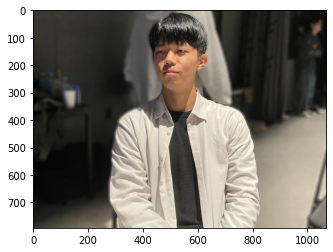

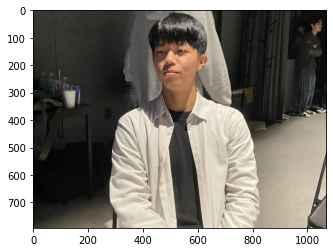

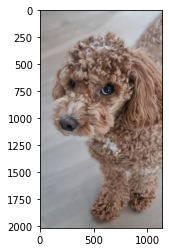

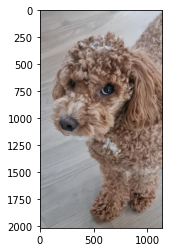

In [72]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


img2_concat = np.where(img2_mask_color==255, img2_orig, img2_bg_blur)
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))
plt.show()
## 비교 해보았더니 확실히 블러가 생겨있음.

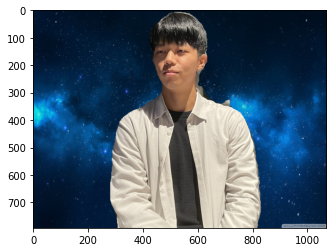

In [74]:
## 배경 전환 크로마키 만들기1

fore = cv2.bitwise_and(img_orig, img_orig, mask = img_mask)
back = cv2.bitwise_and(chroma, chroma, mask = cv2.bitwise_not(img_mask))

# 배경 부분을 치환하는 작업을 거쳐 사람 부분과 합친다.
# 사전에 두 사진은 이미지 픽셀 사이즈를 동일하게 맞춰 놓았음.

img_final = cv2.add(fore,back)

plt.imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
plt.show()

문제점을 찾아보자.

![문제점]("C:/Users/양자/Desktop/Hun_Works/AIFFEL_quest_rs/Exploration/ex04/images/problems.png")

1. 배경 크로마키를 보면 알다시피, 원본사진이 모델 뒤에도 사람이 걸어가는 부분이 겹쳐있어 아마 그 부분 일부가 같이 섞여 들어가 실제로 모델이 아닌 부분도 같이 마스크로 인식되어 있는 것을 알 수 있다.

문제점 분석: Semantic Segmentation 모델이 단순히 RGB 정보만 사용하기 때문에, 전경과 배경이 비슷한 색상이나 패턴을 가지면 모델이 혼동할 가능성이 높다. 이로 인해 모델의 뒤에 있는 다른 사람이 함께 마스크로 포함되는 오류가 발생한다.

원인 분석: DeepLabV3+ 모델은 2D 이미지의 RGB 정보를 기반으로 세그멘테이션을 수행하기 때문에, 깊이 정보(Depth)를 고려하지 못한다. 따라서 동일한 색상의 물체가 배경과 인물 사이에 존재할 경우 오류가 발생할 가능성이 높다.

솔루션 제시: 
1. Depth Estimation 모델을 사용하여 인물과 배경의 거리 차이를 기반으로 마스크를 개선한다. Depth 정보를 활용하면 배경에 있는 사람과 실제 모델을 분리하는 정확도가 향상될 것으로 기대된다.

2. CRF(Conditional random fields)는 세그멘테이션 경계를 보정하여 더 정밀한 마스크를 생성하는 기법이다. 이를 적용하면 인물과 배경의 경계를 더 명확하게 구분할 수 있을 것으로 기대된다.